# Insurance Data Classification: KNN with and without LDA

This notebook compares the performance of a K-Nearest Neighbor (KNN) classifier with and without Linear Discriminant Analysis (LDA) dimensionality reduction.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_excel('ML470_S9_Insurance_Data_Concept.xlsx')

X = df.drop('weight_condition_n', axis=1)
y = df['weight_condition_n']

print("Features:", X.columns.tolist())
print("Target: weight_condition_n")

Features: ['age', 'children', 'charges', 'gender_n', 'smoker_n', 'region_n']
Target: weight_condition_n


## 1. Baseline KNN Classification (Without LDA)

### Split Data and Standardize

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Identify Optimal K

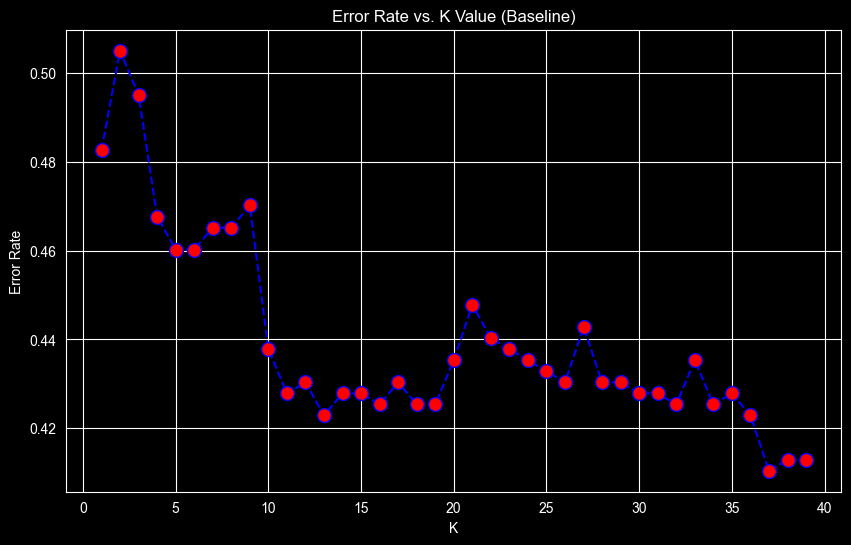

Optimal K: 37


In [3]:
error_rate = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value (Baseline)')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

best_k = error_rate.index(min(error_rate)) + 1
print(f"Optimal K: {best_k}")

### Train and Evaluate Baseline KNN

In [4]:
knn_baseline = KNeighborsClassifier(n_neighbors=best_k)
knn_baseline.fit(X_train_scaled, y_train)
y_pred = knn_baseline.predict(X_test_scaled)
y_prob = knn_baseline.predict_proba(X_test_scaled)

def evaluate_model(y_true, y_pred, y_prob, label):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    
    print(f"--- {label} Performance ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC-AUC': roc_auc}

baseline_results = evaluate_model(y_test, y_pred, y_prob, "Baseline KNN")

--- Baseline KNN Performance ---
Accuracy:  0.5896
Precision: 0.5237
Recall:    0.5896
F1-Score:  0.4990
ROC-AUC:   0.6870


D:\College Theory Stuff\Advanced ML Techniques\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 2. Dimensionality Reduction using LDA

LDA aims to maximize class separability by projecting data onto a lower-dimensional space.

In [5]:
lda = LDA(n_components=min(X.shape[1], len(y.unique()) - 1))
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

print(f"Original shape: {X_train_scaled.shape}")
print(f"Reduced shape: {X_train_lda.shape}")

Original shape: (936, 6)
Reduced shape: (936, 3)


## 3. Rebuild KNN on Reduced-Dimension Data

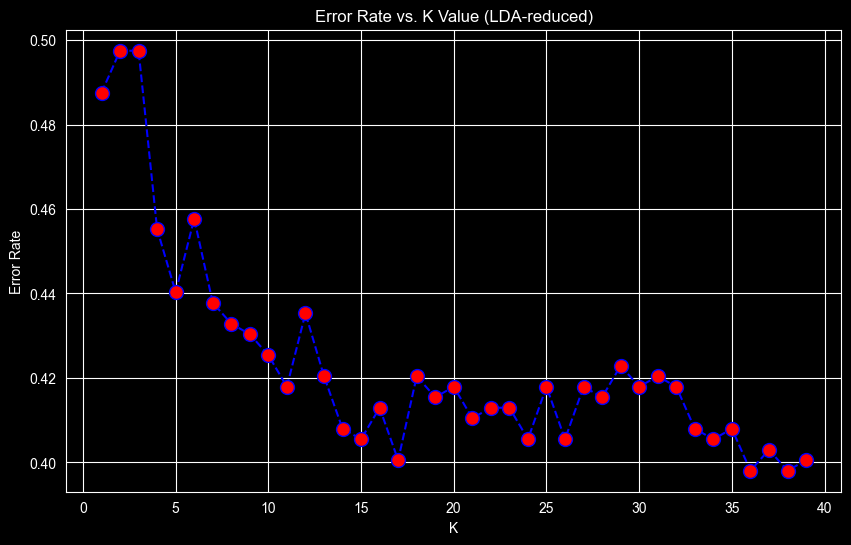

Optimal K (LDA): 36


In [9]:
error_rate_lda = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_lda, y_train)
    y_pred = knn.predict(X_test_lda)
    error_rate_lda.append(1 - accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate_lda, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value (LDA-reduced)')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

best_k_lda = error_rate_lda.index(min(error_rate_lda)) + 1
print(f"Optimal K (LDA): {best_k_lda}")

In [7]:
knn_lda = KNeighborsClassifier(n_neighbors=best_k_lda)
knn_lda.fit(X_train_lda, y_train)
y_pred_lda = knn_lda.predict(X_test_lda)
y_prob_lda = knn_lda.predict_proba(X_test_lda)

lda_results = evaluate_model(y_test, y_pred_lda, y_prob_lda, "LDA-based KNN")

--- LDA-based KNN Performance ---
Accuracy:  0.6020
Precision: 0.5373
Recall:    0.6020
F1-Score:  0.5077
ROC-AUC:   0.6786


D:\College Theory Stuff\Advanced ML Techniques\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 4. Compare Model Performance

              Accuracy  Precision    Recall  F1-Score   ROC-AUC
Baseline KNN  0.589552   0.523681  0.589552  0.499047  0.687039
LDA + KNN     0.601990   0.537313  0.601990  0.507691  0.678612


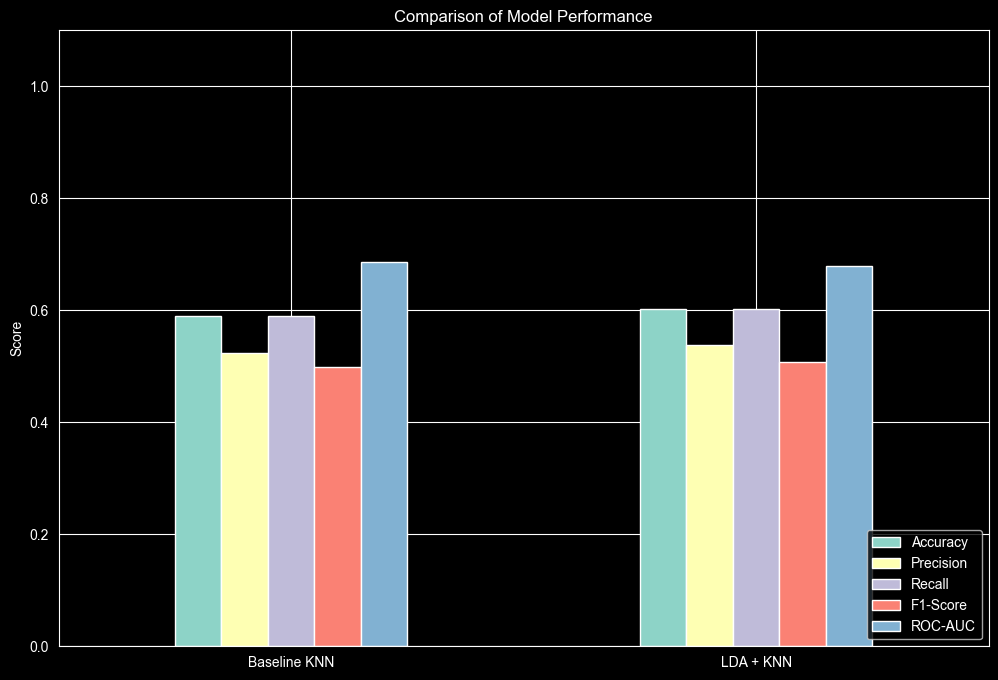

In [8]:
comparison_df = pd.DataFrame([baseline_results, lda_results], index=['Baseline KNN', 'LDA + KNN'])
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.show()